In [1]:
import os
import re
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from tqdm.auto import tqdm
from collections import Counter


In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

MODEL_NAME = "aubmindlab/bert-large-arabertv02"
DATA_PATH = "/kaggle/input/arabic-qa-cleaned/data_cleaned.csv"

MAX_LEN = 384
DOC_STRIDE = 128
BATCH_SIZE = 4
GRAD_ACCUM = 4
EPOCHS = 1
LR = 1.5e-5
MAX_SAMPLES = 60000
WEIGHT_DECAY = 0.01

FP16 = True


Device: cuda


In [3]:
df = pd.read_csv(DATA_PATH)
df = df.dropna(subset=["question", "context", "answer"])

df = df.sample(n=MAX_SAMPLES, random_state=SEED).reset_index(drop=True)

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED)

print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))


Train: 48000
Val: 6000
Test: 6000


In [4]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

tokenizer_config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [5]:
def encode_example(row):
    question = row["question"]
    context = row["context"]
    answer = row["answer"]

    start_char = context.find(answer)
    if start_char == -1:
        return None

    enc = tokenizer(
        question,
        context,
        truncation="only_second",
        max_length=MAX_LEN,
        padding="max_length",
        return_offsets_mapping=True
    )

    offsets = enc["offset_mapping"]
    start_token = end_token = None

    for i, (s, e) in enumerate(offsets):
        if s <= start_char < e:
            start_token = i
        if s < start_char + len(answer) <= e:
            end_token = i

    if start_token is None or end_token is None:
        return None

    enc.pop("offset_mapping")
    enc["start_positions"] = start_token
    enc["end_positions"] = end_token
    return enc


In [6]:
class QADataset(Dataset):
    def __init__(self, df):
        self.data = []
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Encoding"):
            item = encode_example(row)
            if item:
                self.data.append(item)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {k: torch.tensor(v) for k, v in self.data[idx].items()}


In [7]:
train_dataset = QADataset(train_df)
val_dataset = QADataset(val_df)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

print("Train encoded:", len(train_dataset))
print("Val encoded:", len(val_dataset))


Encoding:   0%|          | 0/48000 [00:00<?, ?it/s]

Encoding:   0%|          | 0/6000 [00:00<?, ?it/s]

Train encoded: 36277
Val encoded: 4564


In [8]:
model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)
model.to(DEVICE)


2026-01-17 18:04:41.960689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768673082.152355      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768673082.207103      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768673082.669648      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768673082.669682      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768673082.669685      24 computation_placer.cc:177] computation placer alr

model.safetensors:   0%|          | 0.00/1.48G [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at aubmindlab/bert-large-arabertv02 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64000, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,)

In [9]:
def normalize(text):
    return re.sub(r"\s+", " ", text.strip())

def f1_score(pred, gold):
    p = normalize(pred).split()
    g = normalize(gold).split()
    if not p or not g:
        return int(p == g)
    common = Counter(p) & Counter(g)
    num_same = sum(common.values())
    if num_same == 0:
        return 0.0
    precision = num_same / len(p)
    recall = num_same / len(g)
    return 2 * precision * recall / (precision + recall)

def compute_token_acc(ps, pe, ts, te):
    return np.mean([(p1 == t1 and p2 == t2) for p1, p2, t1, t2 in zip(ps, pe, ts, te)])


In [10]:
def evaluate(model, loader):
    model.eval()
    total_loss, total_em, total_f1 = 0, 0, 0
    ps, pe, ts, te = [], [], [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Validation", leave=False):
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            out = model(**batch)

            loss = out.loss.mean()
            total_loss += loss.item()

            sp = torch.argmax(out.start_logits, dim=1)
            ep = torch.argmax(out.end_logits, dim=1)

            for i in range(len(sp)):
                ids = batch["input_ids"][i]
                pred = tokenizer.decode(ids[sp[i]:ep[i]+1], skip_special_tokens=True)
                gold = tokenizer.decode(
                    ids[batch["start_positions"][i]:batch["end_positions"][i]+1],
                    skip_special_tokens=True
                )
                total_em += int(normalize(pred) == normalize(gold))
                total_f1 += f1_score(pred, gold)

            ps += sp.cpu().tolist()
            pe += ep.cpu().tolist()
            ts += batch["start_positions"].cpu().tolist()
            te += batch["end_positions"].cpu().tolist()

    return (
        total_loss / len(loader),
        total_em / len(loader.dataset),
        total_f1 / len(loader.dataset),
        compute_token_acc(ps, pe, ts, te)
    )


In [11]:
optimizer = AdamW(model.parameters(), lr=LR)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    0,
    EPOCHS * len(train_loader) // GRAD_ACCUM
)
scaler = torch.cuda.amp.GradScaler()

train_losses, val_losses, val_f1s = [], [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for step, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        batch = {k: v.to(DEVICE) for k, v in batch.items()}

        with torch.cuda.amp.autocast():
            out = model(**batch)
            loss = out.loss.mean() / GRAD_ACCUM

        scaler.scale(loss).backward()

        if (step + 1) % GRAD_ACCUM == 0:
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * GRAD_ACCUM

    val_loss, val_em, val_f1, val_acc = evaluate(model, val_loader)

    train_losses.append(total_loss / len(train_loader))
    val_losses.append(val_loss)
    val_f1s.append(val_f1)

    print(f"""
Epoch {epoch+1}
Train Loss : {train_losses[-1]:.4f}
Val Loss   : {val_loss:.4f}
EM         : {val_em:.4f}
F1         : {val_f1:.4f}
Token Acc  : {val_acc:.4f}
""")


/tmp/ipykernel_24/3755404271.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1:   0%|          | 0/9070 [00:00<?, ?it/s]

/tmp/ipykernel_24/3755404271.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/1141 [00:00<?, ?it/s]


Epoch 1
Train Loss : 1.8039
Val Loss   : 1.3892
EM         : 0.6111
F1         : 0.6889
Token Acc  : 0.6091



NameError: name 'val_ems' is not defined

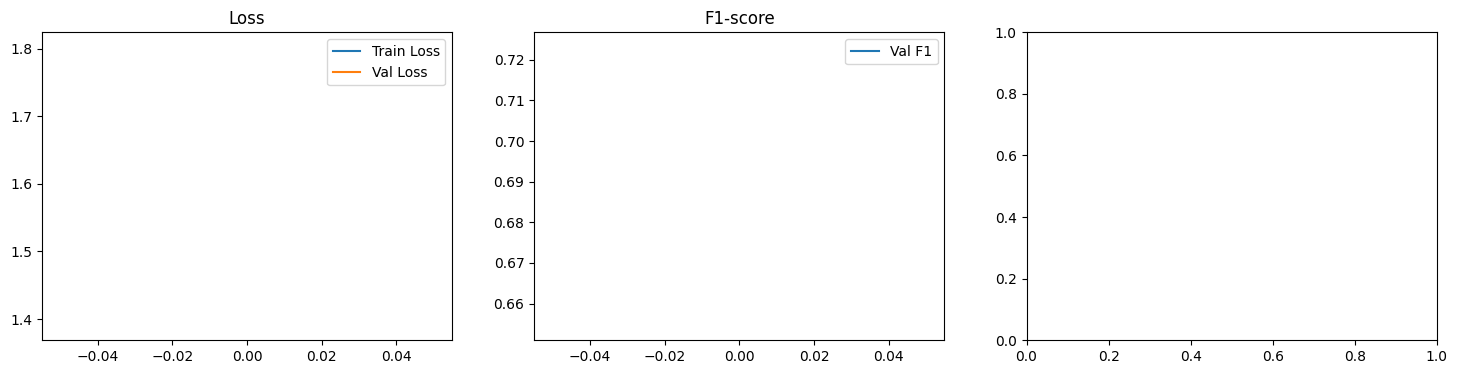

In [12]:
plt.figure(figsize=(18, 4))

# -------- Loss --------
plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss")

# -------- F1 --------
plt.subplot(1, 3, 2)
plt.plot(val_f1s, label="Val F1")
plt.legend()
plt.title("F1-score")

# -------- EM --------
plt.subplot(1, 3, 3)
plt.plot(val_ems, label="Val EM")
plt.legend()
plt.title("Exact Match (EM)")

plt.tight_layout()
plt.show()


In [ ]:
SAVE_DIR = "/kaggle/working/arabert_qa_app"

os.makedirs(SAVE_DIR, exist_ok=True)

model.save_pretrained(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

print("Modèle et tokenizer sauvegardés dans :", SAVE_DIR)


In [ ]:
metrics = {
    "train_loss": train_losses,
    "val_loss": val_losses,
    "val_f1": val_f1s
}

torch.save(metrics, f"{SAVE_DIR}/metrics.pt")

print("Metrics sauvegardées")


In [ ]:
import shutil

zip_path = "/kaggle/working/arabert_qa_app.zip"
shutil.make_archive(
    base_name=zip_path.replace(".zip", ""),
    format="zip",
    root_dir=SAVE_DIR
)

print("ZIP prêt :", zip_path)
